In [ ]:
!python3 -m pip install bs4
!python3 -m pip install nltk
!python3 -m pip install pandas
!python3 -m pip install matplotlib
!python3 -m pip install scikit-learn
!python3 -m pip install wordcloud


In [ ]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob

In [ ]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns

In [ ]:
# Ensure you have VADER downloaded
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('sentiwordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [ ]:
from nltk.corpus import stopwords

# Set up stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
# URL and tickers
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN', 'GOOG', 'AMD', 'TSLA']

In [ ]:
news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)
    html = BeautifulSoup(response, 'html.parser')
    # Find the news table
    news_table = html.find(id='news-table')


    # Add to news_tables if news_table is found, else continue
    if news_table:
        news_tables[ticker] = news_table
    else:
        print(f"No news table found for {ticker}.")
        continue

In [ ]:
# List to hold parsed data
parsed_data = []

In [ ]:
for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        # Ensure both 'a' and 'td' elements exist
        if row.a is not None and row.td is not None:
            title = row.a.text.strip()  # Strip whitespace from the title
            date_data = row.td.text.strip().split(' ')

            # Initialize date and time
            date = ""
            if len(date_data) == 1:
                time = date_data[0]
                date = "Today"  # Defaulting to "Today" if only time is available
            else:
                date = date_data[0]
                time = date_data[1]

            # Append the parsed data to the list
            parsed_data.append([ticker, date, time, title])

In [ ]:
# Create DataFrame
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
vader = SentimentIntensityAnalyzer()

# Calculate sentiment scores
df['compound'] = df['title'].apply(lambda title: vader.polarity_scores(title)['compound'])


In [ ]:

# Handle date conversion more robustly
def parse_dates(date_str):
    if date_str.lower() == "today":
        return pd.to_datetime("today").normalize()  # Use today's date
    try:
        # Attempt to convert to datetime
        return pd.to_datetime(date_str, errors='coerce')  # Coerce errors to NaT
    except Exception as e:
        print(f"Date parsing error for '{date_str}': {e}")
        return pd.NaT  # Return Not-a-Time for unparseable dates

In [ ]:
# Apply date parsing function
df['date'] = df['date'].apply(parse_dates)

# Drop rows with NaT in 'date' column
df = df.dropna(subset=['date'])

In [ ]:
# Ensure 'compound' is numeric
df['compound'] = pd.to_numeric(df['compound'], errors='coerce')

# Drop any NaN values in 'compound' after conversion
df = df.dropna(subset=['compound'])

In [ ]:
# Sentiment category assignment
def categorize_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['compound'].apply(categorize_sentiment)

In [ ]:
# Display the DataFrame
print(df)

    ticker       date     time  \
0     AMZN 2024-11-04  09:41PM   
1     AMZN 2024-11-05  08:07PM   
2     AMZN 2024-11-05  08:00PM   
3     AMZN 2024-11-05  07:32PM   
4     AMZN 2024-11-05  06:30PM   
..     ...        ...      ...   
395   TSLA 2024-11-05  04:00AM   
396   TSLA 2024-10-29  09:25PM   
397   TSLA 2024-11-05  08:11PM   
398   TSLA 2024-11-05  07:30PM   
399   TSLA 2024-11-05  05:36PM   

                                                 title  compound sentiment  
0    Amazon.com Inc (NASDAQ:AMZN) Exceeds Q3 Expect...    0.8074  Positive  
1    Down 88%, Is Wayfair a Top Recovery Stock for ...    0.2023  Positive  
2             Could Roku Be a Millionaire-Maker Stock?    0.0000   Neutral  
3    Amazon Still Backs Talen Nuclear Deal After Re...   -0.4588  Negative  
4    Billionaire Ken Griffin Just Increased His Pos...    0.2732  Positive  
..                                                 ...       ...       ...  
395  A 'lot rides' on Big Tech earnings amid two bu.

In [ ]:
# Function to tokenize titles and remove stopwords
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [ ]:
# ---- New Section: Top Positive, Negative, and Neutral Words for Each Ticker ----
def get_top_words(ticker_df, sentiment):
    words = []
    for title in ticker_df[ticker_df['sentiment'] == sentiment]['title']:
        words.extend(preprocess_text(title))
    return Counter(words).most_common(10)

In [ ]:
# Print top words for each ticker
for ticker in df['ticker'].unique():
    ticker_df = df[df['ticker'] == ticker]
    print(f"Ticker: {ticker}")
    print("Top Positive Words:", get_top_words(ticker_df, 'Positive'))
    print("Top Negative Words:", get_top_words(ticker_df, 'Negative'))
    print("Top Neutral Words:", get_top_words(ticker_df, 'Neutral'))


Ticker: AMZN
Top Positive Words: [('amazon', 36), ('stock', 30), ('apple', 8), ('buy', 8), ('ai', 7), ('earnings', 7), ('stocks', 6), ('market', 6), ('today', 6), ('growth', 5)]
Top Negative Words: [('amazon', 5), ('nuclear', 4), ('big', 4), ('deal', 3), ('stocks', 3), ('apple', 3), ('earnings', 3), ('regulator', 2), ('rejection', 2), ('p', 2)]
Top Neutral Words: [('earnings', 7), ('ai', 7), ('stock', 5), ('spending', 5), ('tech', 5), ('big', 4), ('amazon', 3), ('stocks', 3), ('nvidia', 3), ('investors', 2)]
Ticker: GOOG
Top Positive Words: [('alphabet', 13), ('stock', 11), ('google', 10), ('ai', 8), ('amazon', 8), ('search', 7), ('nvidia', 7), ('growth', 7), ('stocks', 7), ('buy', 7)]
Top Negative Words: [('google', 8), ('ai', 8), ('big', 4), ('spending', 4), ('apple', 3), ('tech', 3), ('stock', 3), ('spree', 3), ('could', 2), ('cloud', 2)]
Top Neutral Words: [('google', 10), ('earnings', 8), ('stock', 8), ('ai', 7), ('big', 5), ('tech', 5), ('search', 5), ('openai', 4), ('buy', 4), (

<Figure size 600x600 with 0 Axes>

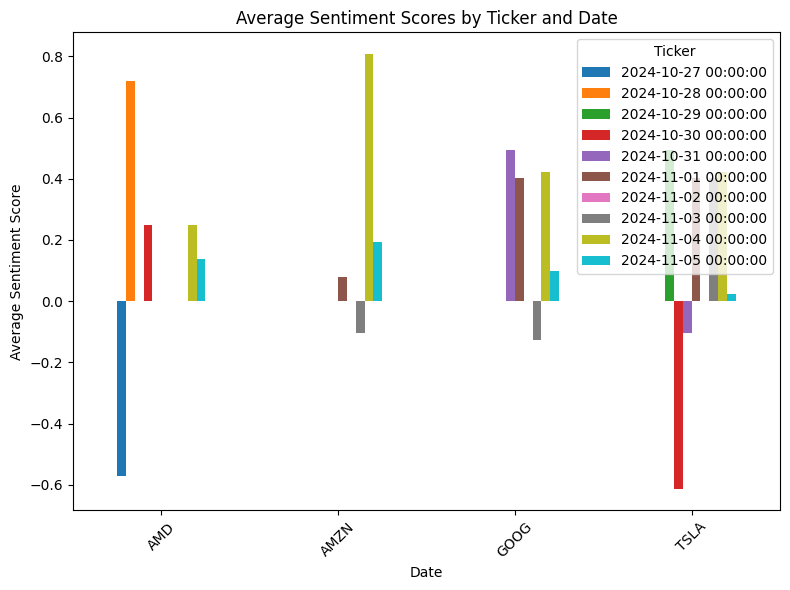

In [ ]:
# Visualize the mean sentiment scores
plt.figure(figsize=(6, 6))
mean_df = df.groupby(['ticker', 'date'])['compound'].mean().unstack()  # Group by ticker and date
mean_df.plot(kind='bar', figsize=(8, 6))
plt.title('Average Sentiment Scores by Ticker and Date')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.legend(title='Ticker')
plt.tight_layout()
plt.show()

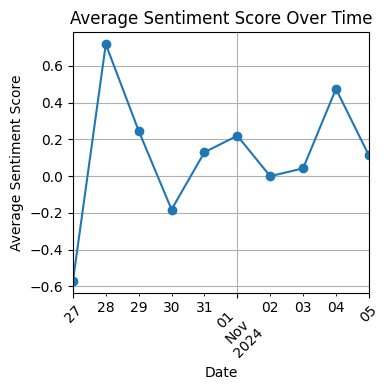

In [ ]:
# Line Plot: Average sentiment over time
plt.figure(figsize=(4, 4))
df.groupby('date')['compound'].mean().plot(kind='line', marker='o')
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

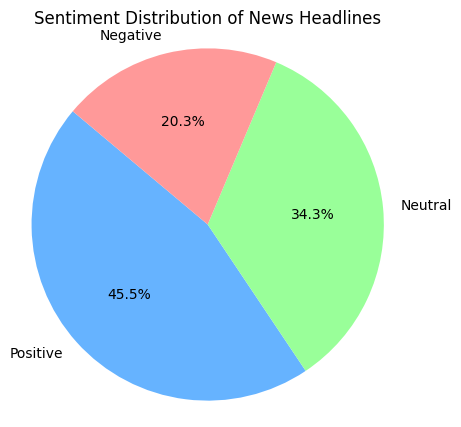

In [ ]:
# Pie Chart: Sentiment Distribution
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ff9999'])
plt.title('Sentiment Distribution of News Headlines')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
plt.show()


In [ ]:

# Function to tokenize titles and remove stopwords
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())  # Tokenize and convert to lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Separate positive and negative sentences based on the compound score
positive_titles = df[df['compound'] > 0]['title']
negative_titles = df[df['compound'] < 0]['title']

# Create lists of words for positive and negative titles
positive_words = []
negative_words = []

for title in positive_titles:
    positive_words.extend(preprocess_text(title))

for title in negative_titles:
    negative_words.extend(preprocess_text(title))

# Create word cloud for positive words
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))

# Create word cloud for negative words
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(negative_words))

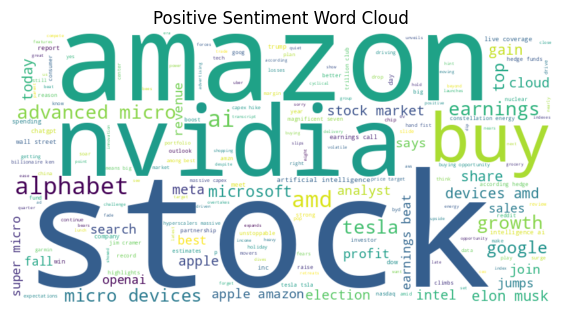

In [ ]:
# Plot the positive word cloud
plt.figure(figsize=(7, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud')
plt.show()  # Display the positive word cloud

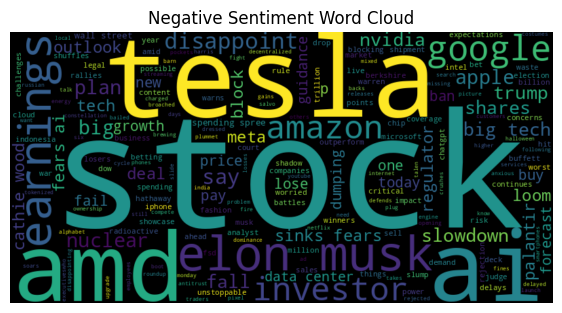

In [ ]:
# Plot the negative word cloud
plt.figure(figsize=(7, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')
plt.show()  # Display the negative word cloud

<ipython-input-29-d455c32b9464>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ticker', y='compound', data=df, palette='Set3')


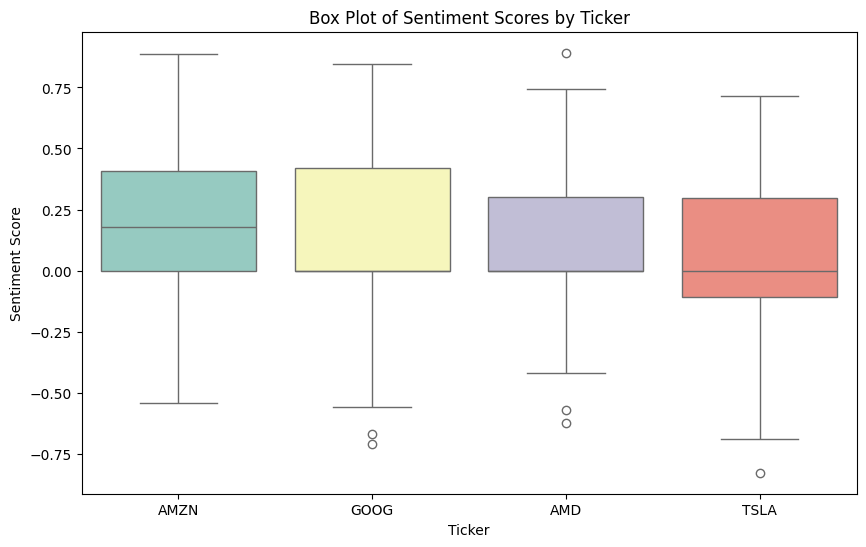

In [ ]:

# Box Plot of sentiment scores for each ticker
plt.figure(figsize=(10, 6))
sns.boxplot(x='ticker', y='compound', data=df, palette='Set3')
plt.title('Box Plot of Sentiment Scores by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Sentiment Score')
plt.show()

In [ ]:
#Print out the most common words
print("Most common positive words:", Counter(positive_words).most_common(10))
print("Most common negative words:", Counter(negative_words).most_common(10))

Most common positive words: [('stock', 62), ('amazon', 46), ('amd', 31), ('ai', 27), ('earnings', 27), ('nvidia', 24), ('alphabet', 23), ('buy', 22), ('micro', 22), ('tesla', 20)]
Most common negative words: [('stock', 19), ('ai', 18), ('amd', 14), ('tesla', 13), ('big', 11), ('elon', 10), ('musk', 10), ('earnings', 9), ('google', 9), ('amazon', 8)]
